In [1]:
from matplotlib import cm, colors, colorbar

# Import MNE, as well as the MNE sample dataset
from mne import io
from mne.datasets import sample
from mne.viz import plot_topomap
from mne.time_frequency import psd_welch
from preprocess import process_eegs
from scipy.stats import ttest_ind
from vae_cp import VAE_CP
import mne
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import TensorFox as tfx
import torch
import torch.nn as nn

In [2]:
ch_names = ['fp1', 'f3', 'f7', 'c3', 't7', 'p3', 'p7', 'o1', 
            'fp2', 'f4', 'f8', 'c4', 't8', 'p4', 'p8', 'o2',
            'fz', 'cz', 'pz']
ch_names = [ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp') for ch_name in ch_names]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

def plot_factors(factors, d=3, factors_name=["Epochs", "Topomap", "Spectrum"]):

    rank = factors[0].shape[1]
    
    # sns.reset_orig()
    fig, all_axs = plt.subplots(rank, d, figsize=(12, int(rank * 2 + 1)))
    
    for ind, (factor, axs) in enumerate(zip(factors[:d], all_axs.T)):
        # axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            if ind == 1:
                mne.viz.plot_topomap(f, info, sensors=False, contours=0, cmap=cm.viridis, show=False, axes=ax)
            else:
                sns.despine(top=True, ax=ax)
                ax.plot(f)
            if ind == 2:
                ax.set_xlabel("Frequency (Hz)")
            all_axs[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    plt.show()

In [3]:
# dims = torch.Size([14052, 19, 45])
# rank=3
# K = 100
model = torch.load("../checkpoints/vae_cp_epoch_4.pth") 
#model = torch.load("checkpoints/vae_cp_epoch_10_rank_4_tanh.pth")
model.eval()
mus = model.mus
lambdas = model.lambdas

epoch_components = mus[0].cpu().detach()
spatial_components = mus[1].cpu().detach()
frequency_components = mus[2].cpu().detach()

# epoch_components[:, 0] = -epoch_components[:, 0]
# spatial_components[:, 0] = -spatial_components[:, 0]

# epoch_components[:,1] = -epoch_components[:,1]
# spatial_components[:,1] = -spatial_components[:,1]

# epoch_components[:,2] = -epoch_components[:,2]
# spatial_components[:,2] = -spatial_components[:,2]

original_factors = [epoch_components, spatial_components, frequency_components]
tfx.change_sign(original_factors)

epoch_std = torch.exp(lambdas[0].cpu().detach())**(0.5)
spatial_std = torch.exp(lambdas[1].cpu().detach())**(0.5)
frequency_std = torch.exp(lambdas[2].cpu().detach())**(0.5)

factors = [epoch_components + epoch_std, spatial_components + spatial_std, frequency_components + frequency_std]
rank = epoch_components.shape[1]

In [4]:
torch.sum(epoch_components[:,0]>=0)
# print(epoch_std)
# print(spatial_std)
# print(frequency_std)

tensor(5051)

In [5]:
#plot_factors(factors)

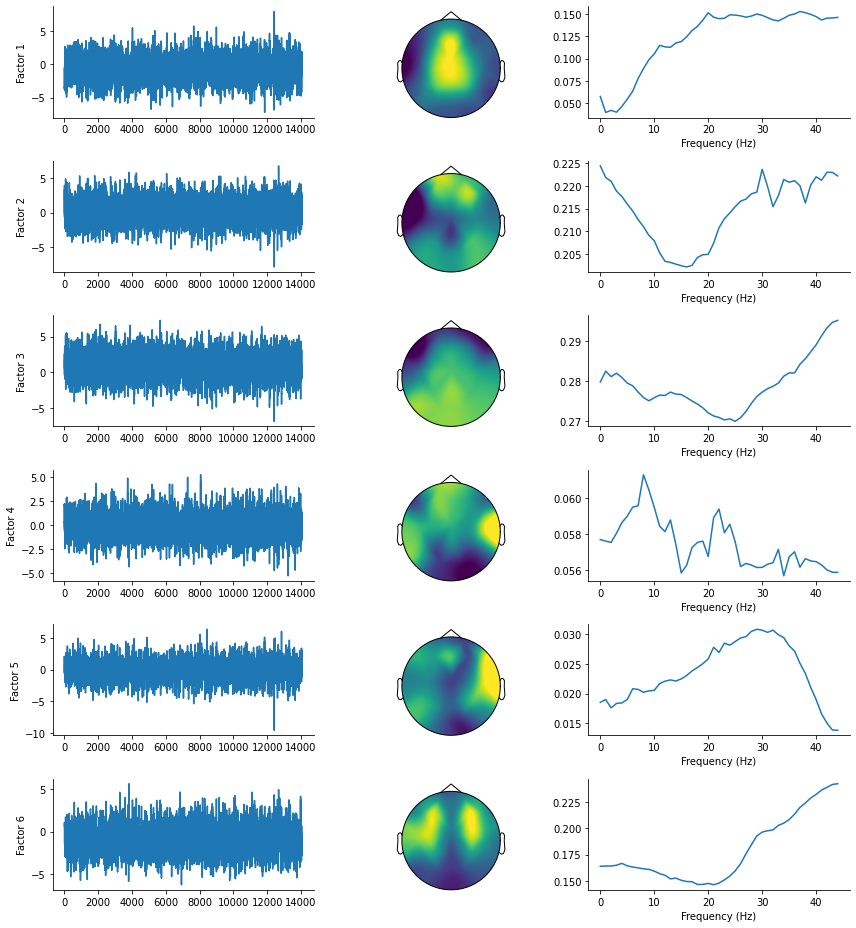

In [6]:
plot_factors(original_factors)

In [7]:
_, _, _, _, _, grade, epi_dx, alz_dx, _, _, _, _ = process_eegs()

abnormal_vs_normal = grade[(epi_dx<0) & (alz_dx<0)]
print(abnormal_vs_normal.shape)

torch.Size([14052])


p-value for Factor 1: 3.1108740919405085e-27


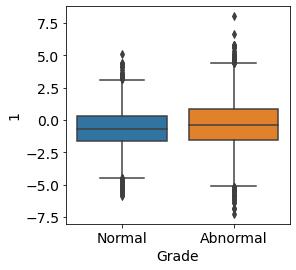

p-value for Factor 2: 6.811811508326091e-66


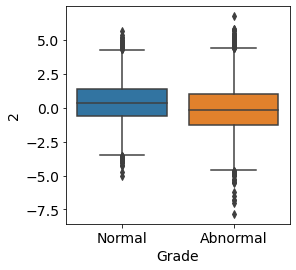

p-value for Factor 3: 2.97609806737937e-96


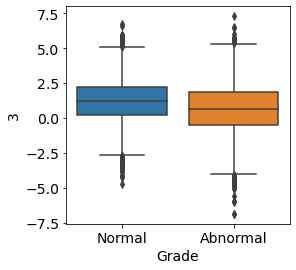

p-value for Factor 4: 2.390901440170744e-78


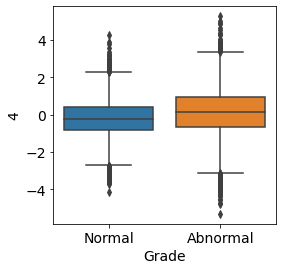

p-value for Factor 5: 2.804382214700518e-06


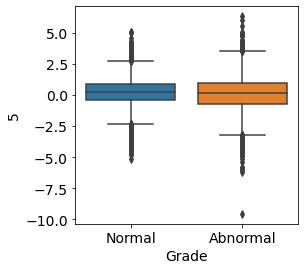

p-value for Factor 6: 2.2958262665034648e-173


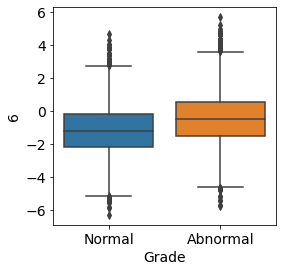

In [8]:
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
for i in range(rank):
    fig, ax = plt.subplots(1,1)
    x = np.array(abnormal_vs_normal[abnormal_vs_normal>=0])
    y = np.array(torch.flatten(epoch_components[:,i])[abnormal_vs_normal>=0])
    
    abnormal = torch.flatten(epoch_components[:,i])[abnormal_vs_normal == 1]
    normal = torch.flatten(epoch_components[:,i])[abnormal_vs_normal == 0]
    t_test = ttest_ind(abnormal, normal)
    print(f"p-value for Factor {i+1}: {t_test.pvalue}")
    sns.boxplot(x=x, y=y, ax=ax)

    plt.xticks(np.arange(2), ['Normal', 'Abnormal'])

    ax.set_xlabel("Grade", {'fontsize' : 14})
    ax.set_ylabel(i+1, {'fontsize' : 14})
    plt.show()